In [4]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

class SegmentationDataset(Dataset):
    def __init__(self, root):
        super(SegmentationDataset, self).__init__()
        self.root = root
        self.img_file = None
        self.mask_file = None
        # self.transform = [transforms.ToTensor(), transforms.RandomHorizontalFlip(1), transforms.RandomVerticalFlip(1), transforms.ToTensor()]
        # self.training = training
        
        # get the img, mask file
        # self.img_file = sorted(glob.glob(os.path.join(self.root, "*_sat.jpg")))
        # self.mask_file = sorted(glob.glob(os.path.join(self.root, "*_mask.png")))
        self.img_file = [os.path.join(self.root, "0013_sat.jpg"), os.path.join(self.root, "0062_sat.jpg"), os.path.join(self.root, "0104_sat.jpg")]
        print(self.img_file)
        # got img, mask 2000
        # print(len(self.img_file))
        # print(len(self.mask_file))
    
    def __getitem__(self, index):
        img = Image.open(self.img_file[index])
        # mask = Image.open(self.mask_file[index])
         
        # if self.training:
        #     tfm = random.choice(self.transform)
        #     img = tfm(img)
        #     if str(tfm) != "ToTensor()":     # if you do the transforms.ToTensor() != tfm: you got two instasnce so it always same
        #         img = transforms.ToTensor()(img)
        #         mask = tfm(mask)
        # else:
        #     img = transforms.ToTensor()(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(mean=[0.4085, 0.3785, 0.2809], std=[0.1155, 0.0895, 0.0772])(img)

        return img
        
    def __len__(self):
        return len(self.img_file)
    
def get_mask(mask):
    
    mask = mask.cpu().numpy()
    index = copy.deepcopy(mask)
    mask = mask.reshape(mask.shape[0], 1, mask.shape[1], mask.shape[2])
    mask_img = mask.repeat(3, axis=1).transpose((0, 2, 3, 1))
    
    mask_img[np.where(index==0)] = np.array([0, 255, 255])
    mask_img[np.where(index==1)] = np.array([255, 255, 0])
    mask_img[np.where(index==2)] = np.array([255, 0, 255])
    mask_img[np.where(index==3)] = np.array([0, 255, 0])
    mask_img[np.where(index==4)] = np.array([0, 0, 255])
    mask_img[np.where(index==5)] = np.array([255, 255, 255])
    mask_img[np.where(index==6)] = np.array([0, 0, 0])
    mask_img = torch.tensor(mask_img.transpose((0, 3, 1, 2)))
    mask_img = torchvision.utils.make_grid(mask_img)
    return imshow(mask_img)
    
def imshow(img):
    img = torch.squeeze(img)
    img = np.array(img)
    img = img.transpose((1, 2, 0))
    # plt.imshow(): (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    plt.imshow(img)
    plt.show()
    return img
# if __name__ == "__main__":

#     train = SegmentationDataset("hw1_data/p3_data/validation")
#     train_loader = DataLoader(train, batch_size=32, shuffle=False, num_workers=4)

#     # # print(imshow(img[0]))

#     for img, mask in train_loader:
#         imshow(torchvision.utils.make_grid(img))
#         get_mask(torchvision.utils.make_grid(mask))
    # img_mean, img_std = 0, 0
    # for img, _ in train:
    #     img_mean += img.mean(dim=(1,2))
    #     img_std += img.std(dim=(1,2))
    # print(img_mean / len(train))
    # print(img_std / len(train))
    # tensor([0.4085, 0.3785, 0.2809])
    # tensor([0.1155, 0.0895, 0.0772])

In [5]:
# data = SegmentationDataset("hw1_data/p3_data/validation/")
# a = None
# b = None
# c = None
# for i, x in enumerate(data):
#     x = x * 255
#     x = torch.reshape(x, shape=(-1, *x.shape))
#     if i == 0:
#         a = x.detach()
#     elif i == 1:
#         b = x.detach()
#     else:
#         c = x.detach()
# mask = torch.cat([a, b, c], dim=0)        
    
# imshow(torchvision.utils.make_grid(mask))


['hw1_data/p3_data/validation\\0013_sat.jpg', 'hw1_data/p3_data/validation\\0062_sat.jpg', 'hw1_data/p3_data/validation\\0104_sat.jpg']
torch.Size([3, 512, 512])


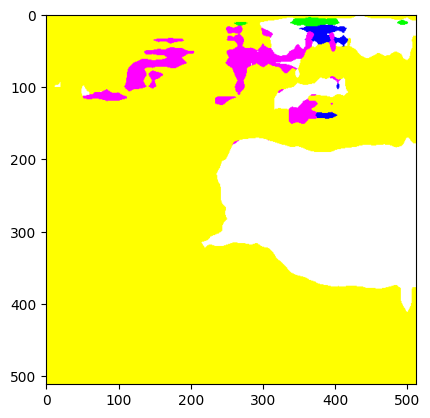

torch.Size([3, 512, 512])


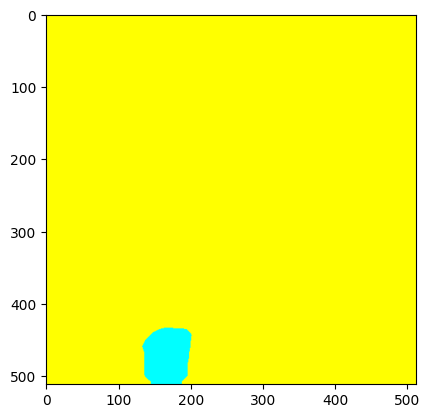

torch.Size([3, 512, 512])


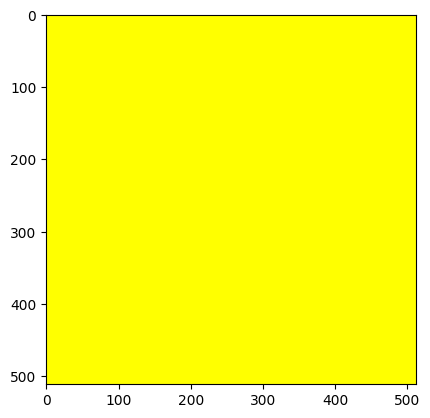

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_resnet101, deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead, FCNHead
import numpy as np
import imageio



DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


valid = SegmentationDataset("hw1_data/p3_data/validation")

# valid_loader = DataLoader(valid, batch_size=3, shuffle=False, num_workers=4)

model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 7, 1, 1)
model.aux_classifier[4] = nn.Conv2d(256, 7, 1, 1)
def mean_iou_score(pred, labels):
    '''
    Compute mean IoU score over 6 classes
    '''
    mean_iou = []
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        if tp == 0 and tp_fn == 0 and tp_fp == 0:
            continue
        iou = tp / (tp_fp + tp_fn - tp)
        # in TA code can't dealt with the nan problem so we have to eliminate this problem
        # print(tp, tp_fn, tp_fp)
        mean_iou.append(iou)
    #     print('class #%d : %1.5f'%(i, iou))
    # print('\nmean_iou: %f\n' % mean_iou)

    return sum(mean_iou) / len(mean_iou)

if __name__ == "__main__":
    model.load_state_dict(torch.load("seg_model_for_three_epoch/epoch_1.pth")) 
    
    # print(model)
    model.to(DEVICE)  
    model.eval() 
    mIoU = []
    
    model.eval()
    with torch.no_grad():
        va_loss = 0
        all_preds = []
        all_gt = []
        
        for i, x in enumerate(valid):
            print(x.shape)
            x = x.to(DEVICE)
            x = torch.reshape(x, shape=(-1, *x.shape))
            out = model(x)['out']
            pred = out.argmax(dim=1)
            # get_mask(pred.detach())
            img = get_mask(pred.detach())
            imageio.imwrite(f'output_image{i}.png', img.astype(np.uint8))
